Predicting Mapping Penalties with a From-Scratch ANN
Saf Flatters

This notebook implements an Artificial Neural Network from scratch to predict task-to-employee assignment penalties, supporting machine learning–based scheduling optimisation.


Instructions for Running:

1. Ensure `population.csv` is in the same directory.
2. Run all cells in order (or 'Run All').
3. This notebook will:
- Load a dataset of 100 task-to-employee mappings from population.csv (see Appendix), each with an associated penalty score.
- Construct 110-dimensional input vectors for each mapping using one-hot and numeric encoding of task and employee features.
- Tune hyperparameters (learning rate, batch size, activation function) for both Model A and Model B using grid search and validation loss.
- Train two feed-forward neural network models from scratch:
    - Model A: Single hidden layer with 256 neurons.
    - Model B: Two hidden layers with 128 neurons each.
- Output the final training, validation, and test Mean Squared Error (MSE) for both models.
- Generate required comparison plots
    1. Epoch vs Loss
    2. Learning Rate vs Loss
    3. Activation Function vs Loss
    4. Batch Size vs Epoch Time

4. Libraries include: `numpy`, `pandas`, `matplotlib`, `random`, `time`.

Notebook has been tested in VS Code & Google Colab

## Imports and Set up:

In [39]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import copy


In [40]:
# Seed for reproducibility

def reset_seed():
    np.random.seed(26)
    random.seed(26)

## Data Loading & Preprocessing:
### Task Data and Employee Data

In [41]:
# Synthetic Task Data #10 tasks
tasks = [
    {"id": "T1", "time": 4, "difficulty": 3, "deadline": 8, "skill": "A"},
    {"id": "T2", "time": 6, "difficulty": 5, "deadline": 12, "skill": "B"},
    {"id": "T3", "time": 2, "difficulty": 2, "deadline": 6, "skill": "A"},
    {"id": "T4", "time": 5, "difficulty": 4, "deadline": 10, "skill": "C"},
    {"id": "T5", "time": 3, "difficulty": 1, "deadline": 7, "skill": "A"},
    {"id": "T6", "time": 8, "difficulty": 6, "deadline": 15, "skill": "B"},
    {"id": "T7", "time": 4, "difficulty": 3, "deadline": 9, "skill": "C"},
    {"id": "T8", "time": 7, "difficulty": 5, "deadline": 14, "skill": "B"},
    {"id": "T9", "time": 2, "difficulty": 2, "deadline": 5, "skill": "A"},
    {"id": "T10", "time": 6, "difficulty": 4, "deadline": 11, "skill": "C"},
]

# Synthetic Employee Data #5 employees
employees = [
    {"id": "E1", "hours": 10, "skill_level": 4, "skills": {"A", "C"}},
    {"id": "E2", "hours": 12, "skill_level": 6, "skills": {"A", "B", "C"}},
    {"id": "E3", "hours": 8, "skill_level": 3, "skills": {"A"}},
    {"id": "E4", "hours": 15, "skill_level": 7, "skills": {"B", "C"}},
    {"id": "E5", "hours": 9, "skill_level": 5, "skills": {"A", "C"}},
]

### Import CSV map


In [42]:
def loadPopulationCSV(path='population.csv'):
    try:
        population = pd.read_csv(path)      # csv to be in submission folder, made by mapping.py (mapping.py is a refined/edited version of Assignment 1 - Group 15 (GeneticFunctions.py))
        return population

    except FileNotFoundError:
        print(f"CSV file not found at path: {path}")
        return None

## Input Vector Construction
### Turn Pair Vectors into One Input Vector

In [43]:
# Functions to support createArrays():

def createVectors(population_df):
    input_vector = []       # features x
    penalties = []          # labels y

    for _, row in population_df.iterrows():
        penalty = float(row['Penalty'])
        chromosome_raw = row['Chromosome']
        chromosome = list(map(int, chromosome_raw.strip("[]").split(","))) # convert string to list
        input_vector.append(chromoVector(chromosome))       # turn 10 int chromosome into a 110 int input vector and add to list
        penalties.append(penalty)

    return input_vector, penalties


# To maintain the format provided in the Assignment Brief for global dictionaries these 2 functions will associate "id" with integers
# Use these functions instead of: 'E' + str(genome_employee), 'T' + str(genome_task)

def formatEmpID(emp_num):
    return f"E{emp_num}"

def formatTaskID(task_num):
    return f"T{task_num}"

def oneHotSkills(skill):        # given a skill string - encode 0,0,0 to match list
    if isinstance(skill, str):      # if string (like in tasks)
        skills = skill.split(',')
    if isinstance(skill, set):         # if set (like in employees)
        skills = skill

    encoding = [0, 0, 0]   # [A, B, C]

    for s in skills:
        skill = s.strip().upper()       # make uppercase
        if s == 'A':
            encoding[0] = 1
        elif s == 'B':
            encoding[1] = 1
        elif s == 'C':
            encoding[2] = 1
        else:
            print(f"Warning: Skill '{skill}' not recognised. Skipped.")     # exception handling

    return encoding[0], encoding[1], encoding[2]    # return 3 binaries


def taskVector(genome_task):        # vectorise tasks (returns 6 elements)
    matched_task = None
    for task in tasks:
        if task["id"] == genome_task:
            matched_task = task

    encoded_skill = oneHotSkills(matched_task['skill'])

    return [matched_task['time'], matched_task['difficulty'], matched_task['deadline'], encoded_skill[0], encoded_skill[1], encoded_skill[2]]


def employeeVector(genome_employee):      # vectorise employees (returns 5 elements)
    matched_employee = None
    for employee in employees:
        if employee["id"] == genome_employee:
            matched_employee = employee

    encoded_skill = oneHotSkills(matched_employee['skills'])

    return [matched_employee['hours'], matched_employee['skill_level'], encoded_skill[0], encoded_skill[1], encoded_skill[2]]


def pairVector(genome_task, genome_employee):       # vector a Task-Employee pair

    return taskVector(genome_task) + employeeVector(genome_employee)


def chromoVector(chromosome):       # vector entire chromosome (10 pairings)
    full_vector = []

    for i, E in enumerate(chromosome):          # index = i, value = E
        genome_task = formatTaskID(i + 1)       # returns 'T1'...
        genome_employee = formatEmpID(E)        # returns 'E1'...
        partial_vector = pairVector(genome_task, genome_employee)   # returns 11 number list from one pairing
        full_vector.extend(partial_vector)      # adds each 11 number list to full vector

    return full_vector      # returns 110 number list (1 chromosome with each pairing has 11 numbers)

### Create Arrays from Input and Penalty Vectors

In [44]:
# create arrays function:
def createArrays(population_df):
    input_vector, penalties = createVectors(population_df)

    # return X and y into arrays (learnt in COMP3009):
    X = np.array(input_vector)              # X array shape is (100, 110) <- 100 rows for 100 chromosomes & 110 columns for features of each chromosome
    y = np.array(penalties).reshape(-1, 1)  # y array shape is (100, 1)  <- 100 rows of 1 x penalty cost for each chromosome

    return X, y


In [45]:
#### Testing Input Vectors


# ## confirm 100 mappings (chromosome + penalty)
# population = createMapping(100)     # this is list of all chromosomes with cost in format [(cost1, [chromosome1]), (cost2, [chromosome2]), ...]
# # print('Population: ', population)
# print('Population len: ', len(population))

# ## confirm input vector (110) with penalty score
# input_vector = []       # features x
# penalties = []          # labels y
# for cost, chromosome in population:     # for each chromosome
#     input_vector.append(chromoVector(chromosome))       # turn 10 int chromosome into a 110 int input vector and add to list
#     penalties.append(cost)

# print('Input Vectors: ', input_vector)
# print('Penalties: ', penalties)
# print('Input Vectors len: ', len(input_vector))
# print('Penalties len: ', len(penalties))

# print('1 Input Vector len: ', len(input_vector[0]))

## ANN Implementation

### Network Shape Options - A & B

In [46]:
# Set Network Architecture shape -
# Model A (110 input) -> (256 hidden1)  -> (1 output)
# Model B (110 input) -> (128 hidden1) -> (128 hidden2) -> (1 output)

def networkShape(shape='A'):        # called by feedForward
    if shape == 'A':
        network_shape = [110, 256, 1]
    elif shape == 'B':
        network_shape = [110, 128, 128, 1]
    else:
        raise ValueError("Network Shape must be 'A' or 'B' - please try again")

    return network_shape

### Initialise Parameters (weights and biases)

Model A:
W1 <- from Input Node (110 nodes) to each 256 activation functions = 28,160 weights in W1
B1 <- 1 bias per activation function = 256 biases in B1
W2 <- from 256 activation functions to 1 output node = 256 weights in W2
B2 <- 1 bias per output node = 1 bias in B2

Model B:
W1 <- from Input Node (110 nodes) to each 128 activation functions = 14,080 weights in W1
B1 <- 1 bias per activationfunction1 = 128 biases in B1
W2 <- from 128 activationfunction1 to 128 activationfunction2 = 16,384 weights in W2
B2 <- 1 bias per 128 activationfunction2 = 128 bias in B2
W3 <- from 128 activationfunction2 to 1 output node = 128 weights in W3
B3 <- 1 bias per output node = 1 bias in B3

In [47]:
def starterParameters(network_shape):   # called by feedForward
    parameters = {}     # dictionary of weights and bias arrays - named W1, b1 etc.
    for layer in range(1, len(network_shape)):
        parameters[f'W{layer}'] = np.random.randn(network_shape[layer], network_shape[layer - 1]) * 0.01        # (current layer neurons, previous layer neurons)
        parameters[f'b{layer}'] = np.zeros((network_shape[layer], 1))       # column vector (nodes, 1)

    return parameters

# tester code
# params = starterParameters(networkShape('A'))
# for name, value in params.items():
#     print(f"{name}: shape = {value.shape}, total elements = {value.size}")

# params = starterParameters(networkShape('B'))
# for name, value in params.items():
#     print(f"{name}: shape = {value.shape}, total elements = {value.size}")


### Activation Functions

Non-linear activation functions in hidden layers
Options:
1. Sigmoid
2. ReLU

In [48]:
def activationFunction(z, function_type='Relu'):    # called by feedForward
    if function_type.upper() == 'SIGMOID':
        return 1 / (1 + np.exp(-z))
    elif function_type.upper() == 'RELU':
        return np.maximum(0, z)     # if z is +: returns z, if z is -: returns 0
    else:
        raise ValueError("Function type must be 'Sigmoid' or 'ReLU'")

### Feed-Forward Propogation

In [49]:
def feedForward(x_array, network_shape, parameters, activation_type, seed=None):
    a = x_array.T        # Initial input layer transposed - each chromosomes has a column, Feature 1 is row 1 (dot product W_array's columns must match a's rows)
    cache = {"A0": a}   # store activations and z's into dictionary - including initial input layer

    for i in range(1, len(network_shape)):
        W_array = parameters[f'W{i}']
        b_array = parameters[f'b{i}']
        z = W_array @ a + b_array  # dot product of weight with a, then + bias
        cache[f"Z{i}"] = z

        if i != len(network_shape) - 1:         # if not output layer
            a = activationFunction(z, activation_type)      # phi(z)
        else:
            a = z       # output layer to remain linear

        cache[f"A{i}"] = a

    return a.T, cache      # Transpose back: return shape (num_chromosomes, 1) for consistency with y (penalties) for predictions later

### Backpropogation Algorithm

In [50]:
def meanSquaredError(N, predicted, actual):
    loss = np.mean((actual - predicted)**2)      # MSE = (1/N) * sum(actual - predicted)**2

    return loss         # float


def activationDerivative(z, function_type):     # computes the deriviative of an activation function (ReLU or Sigmoid)
    if function_type.upper() == 'RELU':
        return (z > 0).astype(float)            # Deriviative of ReLU: 1 if positive, 0 if 0 or negative
    elif function_type.upper() == 'SIGMOID':
        sig = 1 / (1 + np.exp(-z))              # compute sigmoid $\frac{1}{1+ e^{-x}}$
        return sig * (1 - sig)                  # Deriviative of sigmoid
    else:
        raise ValueError("Unsupported activation type")


def backwardsPropogation(X_train, y_train, cache, network_shape, parameters, activation_type, learning_rate):       # how to estimate the weights and biases (after Inital run)
    X_size = X_train.shape[0]                       # number of training samples in batch
    num_layers = len(network_shape) - 1             # number of layers (excluding input)
    grads = {}                                      # Dictionary to store gradients
    y_trainT = y_train.T                            # Transpose y to match predictions   *
    y_predictions = cache[f"A{num_layers}"]         # Final layers predictions passed in

    # 1. Error at output later (MSE loss)
    dZ = y_predictions - y_trainT                   # dZ = final layer predictions - actual predictions

    # 2. Backpropogation through all layers from output to input
    for i in reversed(range(1, num_layers + 1)):        # go backwards
        A_previous = cache[f"A{i-1}"]               # Activations from previous layer
        W = parameters[f"W{i}"]                 # weights at current layer
        # compute gradients
        grads[f"dW{i}"] = dZ @ A_previous.T / X_size        # gradient of weight (dW) = (1/n) *  dZ(error at output layer) dot (previous layer activations)
        grads[f"db{i}"] = np.sum(dZ, axis=1, keepdims=True) / X_size        #gradient normalisation - divide by batch size
        if i > 1:   # for all layers except input, backprop to next layer - #chain rule
            Z_previous = cache[f"Z{i-1}"]       # previous layer before activation
            dA_previous = W.T @ dZ              # propogate error back through weights
            dZ = dA_previous * activationDerivative(Z_previous, activation_type)    # element wise calc of previous layer z with deriviative of z

    # 3. Update weights and biases using gradient descent
    for j in range(1, num_layers + 1):
        parameters[f"W{j}"] -= learning_rate * grads[f"dW{j}"]
        parameters[f"b{j}"] -= learning_rate * grads[f"db{j}"]

    return parameters       # updated parameters after one backwards pass


## Training Loop & Hyperparameter Tuning
### Split Train, Validation, Test Sets

In [51]:
def splitTrainValTestSets(X, y):
    # Assign the first 70 mappings to the training set, the next 15 to the validation set, and the final 15 to the test set. (out of 100)
    X_train = X[:70]
    y_train = y[:70]

    X_val = X[70:85]
    y_val = y[70:85]

    X_test = X[85:]
    y_test = y[85:]

    return X_train, y_train, X_val, y_val, X_test, y_test

### Training Loop

In [52]:
## Supporting functions for training loop:

def shuffleTrainingData(X, y):      # shuffle training set - keep X_train and y_train aligned even after shuffle
    index = np.arange(X.shape[0])
    np.random.shuffle(index)

    return X[index], y[index]


def trainEpoch(X_train, y_train, parameters, network_shape, activation_type, learning_rate, batch_size):

    # batch_loss_history = []

    for start_idx in range(0, X_train.shape[0], batch_size):    # partition into mini batches of chosen size - for mini-batch gradient descent (updates weights multiple times per epoch)
        end_idx = start_idx + batch_size
        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        # c) for each mini batch: 1. forward prop, compute batch loss, backwards prop
        predicted_penalties, cache = feedForward(X_batch, network_shape, parameters, activation_type)

        # compute batch loss (MSE)
        # batch_loss = meanSquaredError(len(X_batch), predicted_penalties, y_batch)
        # batch_loss_history.append(batch_loss)

        parameters = backwardsPropogation(X_batch, y_batch, cache, network_shape, parameters, activation_type, learning_rate)

    # d) At end of epoch: 1 last feed-forward
    predicted_penalties, cache = feedForward(X_train, network_shape, parameters, activation_type)

    return parameters, predicted_penalties, cache


# Training loop:

def trainingLoop(shape, iterations, activation_type, learning_rate, batch_size, X_train, y_train, X_val, y_val, training=False):

    # Store loss history
    train_loss_history = []
    val_loss_history = []

    epoch_times = []


    # Step 3: INITIAL Run - set parameters
    network_shape = networkShape(shape)                           # "A" or "B" for Layers: [110, 256, 1] or [110, 128, 128, 1]
    parameters = starterParameters(network_shape)     # dictionary of initial weights and biases (w1 = , b1 = ,...,  w_n = , b_n = )


    # EARLY STOPPING VARIABLES - to stop iterations once val loss is not improving <- this is useful if E > 5000
    best_val_loss = float('inf')
    best_parameters = None
    patience = 150   # Number of epochs with no improvement before stopping
    counter = 0     # How many in a row have not improved
    best_epoch = 0

    # Step 4: Training Loop
    for epoch in range(iterations):
        start_time = time.time()    # start timer

        # a) shuffle training set - keep X_train and y_train aligned even after shuffle
        X_train, y_train = shuffleTrainingData(X_train, y_train)

        # b) partition into mini batches of chosen size - for mini-batch gradient descent (updates weights multiple times per epoch)
        # c) for each mini batch: 1. forward prop, compute batch loss, backwards prop,
        parameters, predicted_penalties, _ = trainEpoch(X_train, y_train, parameters, network_shape, activation_type, learning_rate, batch_size)

        # d) At end of epoch: 1 last feed-forward (completed in trainEpoch), Eval training/val loss and epoch time
            # Training loss
        train_loss = meanSquaredError(len(X_train), predicted_penalties, y_train)
        train_loss_history.append(train_loss)

            # Validation loss
        val_pred_penalties, _ = feedForward(X_val, network_shape, parameters, activation_type)  # no backwards prop
        val_loss = meanSquaredError(len(X_val), val_pred_penalties, y_val)
        val_loss_history.append(val_loss)

        end_time = time.time()  # stop timer
        epoch_times.append(end_time - start_time)

        # EARLY STOPPING - for Training only!
        if training == True:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_parameters = copy.deepcopy(parameters)  # Save best model
                best_epoch = epoch
                counter = 0  # Reset counter on improvement
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} (patience={patience})")
                    break


        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    if best_parameters:     # if stopped early:
        return train_loss_history, val_loss_history, epoch_times, best_epoch, best_parameters
    else:
        return train_loss_history, val_loss_history, epoch_times, best_epoch, parameters




### Hyperparameter Grid

In [53]:
def tuneHyper(shape, X_train, y_train, X_val, y_val):       # find best hyper parameters for Shape A and shape B
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes = [8, 16, 32]
    activation_types = ["ReLU", "Sigmoid"]
    epochs = 200

    results = []

    for rate in learning_rates:
        for batch_size in batch_sizes:
            for activation in activation_types:
                # print(f"Training with LR={rate}, Batch={batch_size}, Activation={activation}")

                # Shape A or B
                train_loss, val_loss, epoch_times, _, _ = trainingLoop(shape, epochs, activation, rate, batch_size, X_train, y_train, X_val, y_val)   # training = False <- so no early stopping

                result = {
                    "learning_rate": rate,
                    "batch_size": batch_size,
                    "activation": activation,
                    "final_train_loss": train_loss[-1],
                    "best_val_loss": min(val_loss),
                }
                results.append(result)

    hyper_results = pd.DataFrame(results)
    # print(f"\n***Results for shape {shape}:***")
    # print(hyper_results)

    best_val = hyper_results.sort_values(by="best_val_loss").iloc[0]   # sort by lowest_val_loss (ascending)
    # print(f"\nBest hyperparameters for model {shape} based on validation loss: \n{best_val}")

    return best_val["activation"], best_val["learning_rate"], best_val["batch_size"]



## Run, Evaluation & Results

### Run Code

In [54]:
# Set global seed
# np.random.seed(26)
# random.seed(26)

reset_seed()

E = 200          # number of epochs/iterations

print("Model Shape A: [110 > 256 > 1]")
print("Model Shape B: [110 > 128 > 128 > 1]")

# Create input_vectors (100, 110) and penalty arrays (100, 1) - imports CSV file population.csv
X, y = createArrays(loadPopulationCSV())    # N = 100

# Split into training, validation, and test sets
X_train, y_train, X_val, y_val, X_test, y_test = splitTrainValTestSets(X, y)

# Tune Hyperparameters for shape A & shape B (best found with lowest validation loss)
A_activation_type, A_learning_rate, A_batch_size = tuneHyper("A", X_train, y_train, X_val, y_val)
B_activation_type, B_learning_rate, B_batch_size = tuneHyper("B", X_train, y_train, X_val, y_val)
print(f"\nFinal Hyperparameters set on model shape A: Activation Function= {A_activation_type}, Learning Rate= {A_learning_rate}, Batch Size= {A_batch_size}")
print(f"Final Hyperparameters set on model shape B: Activation Function= {B_activation_type}, Learning Rate= {B_learning_rate}, Batch Size= {B_batch_size}")

# Run Training Loop for shape A and shape B with tuned hyperparameters      # def trainingLoop(shape, iterations, activation_type, learning_rate, batch_size, X_train, y_train, X_val, y_val, training=False):
A_train_loss, A_val_loss, A_epoch_times, A_best_epoch, A_best_parameters = trainingLoop("A", E, A_activation_type, A_learning_rate, A_batch_size, X_train, y_train, X_val, y_val, training=True)
B_train_loss, B_val_loss, B_epoch_times, B_best_epoch, B_best_parameters = trainingLoop("B", E, B_activation_type, B_learning_rate, B_batch_size, X_train, y_train, X_val, y_val, training=True)
print(f"\nBest Epoch for model shape A: {A_best_epoch}")
print(f"Best Epoch for model shape B: {B_best_epoch}")
print(f"\nBest Epoch Train MSE of model shape A: {A_train_loss[A_best_epoch]:.4f}")
print(f"Best Epoch Train MSE of model shape B: {B_train_loss[B_best_epoch]:.4f}")
print(f"\nBest Epoch Validation MSE of model shape A: {A_val_loss[A_best_epoch]:.4f}")
print(f"Best Epoch Validation MSE of model shape B: {B_val_loss[B_best_epoch]:.4f}")

# Evaluate final models on test set
A_test_pred_penalties, _ = feedForward(X_test, networkShape("A"), A_best_parameters, A_activation_type)
A_test_loss = meanSquaredError(len(X_test), A_test_pred_penalties, y_test)
print(f"\nFinal Test MSE of model shape A: {A_test_loss:.4f}")

B_test_pred_penalties, _ = feedForward(X_test, networkShape("B"), B_best_parameters, B_activation_type)
B_test_loss = meanSquaredError(len(X_test), B_test_pred_penalties, y_test)
print(f"Final Test MSE of model shape B: {B_test_loss:.4f}")




Model Shape A: [110 > 256 > 1]
Model Shape B: [110 > 128 > 128 > 1]

Final Hyperparameters set on model shape A: Activation Function= Sigmoid, Learning Rate= 0.01, Batch Size= 8
Final Hyperparameters set on model shape B: Activation Function= ReLU, Learning Rate= 0.01, Batch Size= 8

Best Epoch for model shape A: 194
Best Epoch for model shape B: 156

Best Epoch Train MSE of model shape A: 0.5079
Best Epoch Train MSE of model shape B: 0.4314

Best Epoch Validation MSE of model shape A: 0.6516
Best Epoch Validation MSE of model shape B: 0.5489

Final Test MSE of model shape A: 1.1946
Final Test MSE of model shape B: 1.0785


### Summary Table

In [55]:
display_results = pd.DataFrame({
    "Model A": {
        "Architecture": "[110 > 256 > 1]",
        "Activation": A_activation_type,
        "Learning Rate": A_learning_rate,
        "Batch Size": A_batch_size,
        "Best Training Epoch": A_best_epoch,
        "Best Epoch Train MSE": round(A_train_loss[A_best_epoch], 6),
        "Best Epoch Validation MSE": round(A_val_loss[A_best_epoch], 6),
        "Final Test MSE": round(A_test_loss, 6),
        "Average Epoch Time (s)": round(np.mean(A_epoch_times), 6)
    },
    "Model B": {
        "Architecture": "[110 > 128 > 128 > 1]",
        "Activation": B_activation_type,
        "Learning Rate": B_learning_rate,
        "Batch Size": B_batch_size,
        "Best Training Epoch": B_best_epoch,
        "Best Epoch Train MSE": round(B_train_loss[B_best_epoch], 6),
        "Best Epoch Validation MSE": round(B_val_loss[B_best_epoch], 6),
        "Final Test MSE": round(B_test_loss, 6),
        "Average Epoch Time (s)": round(np.mean(B_epoch_times), 6)
    }
})

print("\nFinal Results Summary:")
display(display_results)


Final Results Summary:


,Model A,Model B
Architecture,[110 > 256 > 1],[110 > 128 > 128 > 1]
Activation,Sigmoid,ReLU
Learning Rate,0.01,0.01
Batch Size,8,8
Best Training Epoch,194,156
Best Epoch Train MSE,0.507915,0.431352
Best Epoch Validation MSE,0.65162,0.548902
Final Test MSE,1.194609,1.078493
Average Epoch Time (s),0.005239,0.004864


## Comparison Graphs
1. Epoch vs Loss
2. Learning Rate vs Loss
3. Activation Function vs Loss
4. Batch Size vs Epoch Time

In [56]:
train_col = '#F8766D'
val_col = '#00BFC4'

shapeA_col = '#6A5ACD'
shapeB_col = '#CC5500'

shapeA_bgcol = '#b3afc9'
shapeB_bgcol = '#ccac95'


### Epoch Vs Loss

Early stopping at epoch 180 (patience=150)


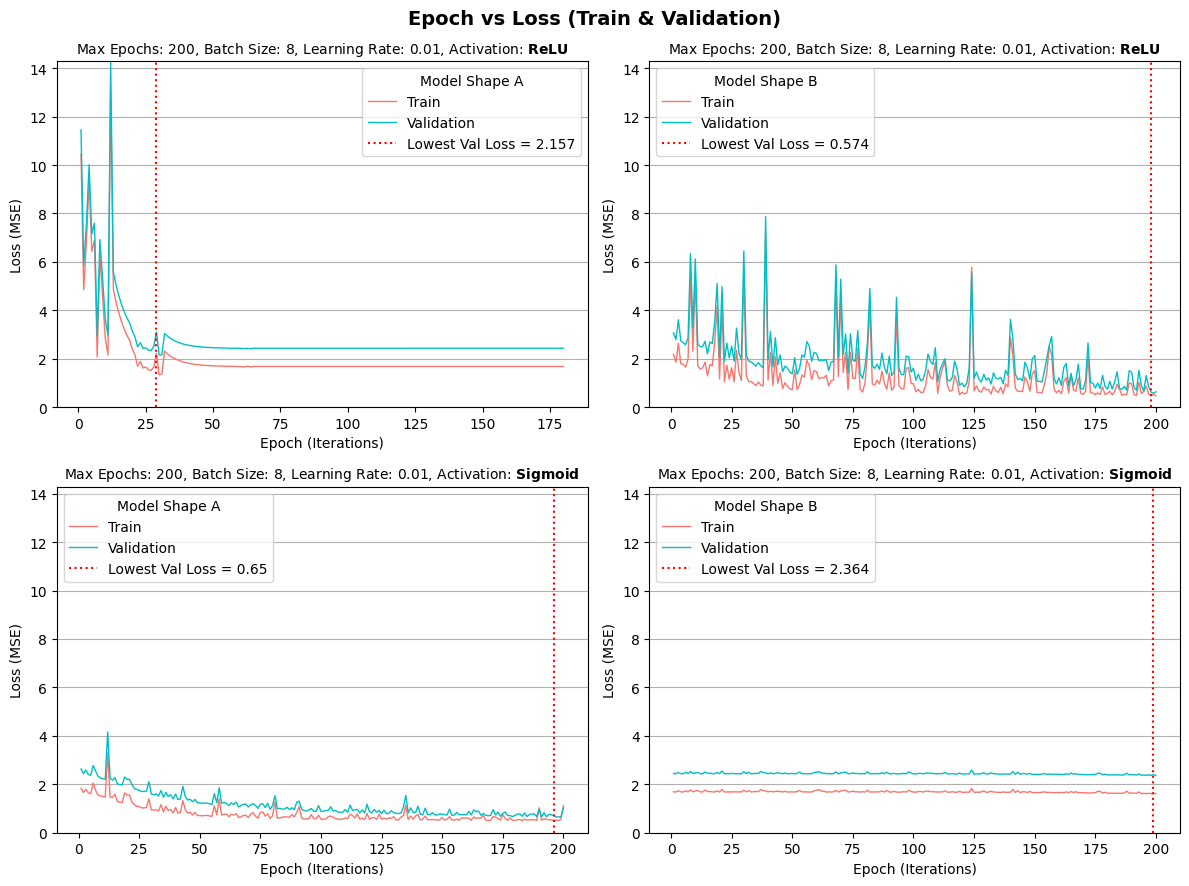

In [57]:
plt.rcParams["text.usetex"] = False  # Must be False for \textbf{} with mathtext

E = 200

A_relu_train_loss = []
A_relu_val_loss = []
A_relu_best_epoch = 0

A_sigmoid_train_loss = []
A_sigmoid_val_loss = []
A_sigmoid_best_epoch = 0

B_relu_train_loss = []
B_relu_val_loss = []
B_relu_best_epoch = 0

B_sigmoid_train_loss = []
B_sigmoid_val_loss = []
B_sigmoid_best_epoch = 0


# Model A - ReLU
reset_seed()
train_loss, val_loss, _, best_epoch, _ = trainingLoop("A", E, 'ReLU', 0.01, 8, X_train, y_train, X_val, y_val, training=True)
A_relu_train_loss = train_loss
A_relu_val_loss = val_loss
A_relu_best_epoch = best_epoch

# Model B - ReLU
reset_seed()
train_loss, val_loss, _, best_epoch, _ = trainingLoop("B", E, 'ReLU', 0.01, 8, X_train, y_train, X_val, y_val, training=True)
B_relu_train_loss = train_loss
B_relu_val_loss = val_loss
B_relu_best_epoch = best_epoch

# Model A - Sig
reset_seed()
train_loss, val_loss, _, best_epoch, _ = trainingLoop("A", E, 'Sigmoid', 0.01, 8, X_train, y_train, X_val, y_val, training=True)
A_sigmoid_train_loss = train_loss
A_sigmoid_val_loss = val_loss
A_sigmoid_best_epoch = best_epoch

# Model B - Sig
reset_seed()
train_loss, val_loss, _, best_epoch, _ = trainingLoop("B", E, 'Sigmoid', 0.01, 8, X_train, y_train, X_val, y_val, training=True)
B_sigmoid_train_loss = train_loss
B_sigmoid_val_loss = val_loss
B_sigmoid_best_epoch = best_epoch

fig, ax = plt.subplots(2, 2, figsize=(12, 9))

# x-axes
epochs_A_relu = list(range(1, len(A_relu_train_loss) + 1))
epochs_A_sig = list(range(1, len(A_sigmoid_train_loss) + 1))
epochs_B_relu = list(range(1, len(B_relu_train_loss) + 1))
epochs_B_sig = list(range(1, len(B_sigmoid_train_loss) + 1))

# Plot A ReLU
ax[0][0].plot(epochs_A_relu, A_relu_train_loss, label='Train', linewidth=1, color=train_col)
ax[0][0].plot(epochs_A_relu, A_relu_val_loss, label='Validation', linewidth=1, color=val_col)
ax[0][0].axvline(A_relu_best_epoch, color='red', linestyle=':', label=f'Lowest Val Loss = {round(A_relu_val_loss[A_relu_best_epoch], 3)}')
ax[0][0].set_title(f"Max Epochs: {E}, Batch Size: 8, Learning Rate: 0.01, Activation: " + r"$\bf{ReLU}$", fontsize=10)
ax[0][0].set_xlabel('Epoch (Iterations)')
ax[0][0].set_ylabel('Loss (MSE)')
ax[0][0].legend(title='Model Shape A')
ax[0][0].grid(True)

# Plot B ReLU
ax[0][1].plot(epochs_B_relu, B_relu_train_loss, label='Train', linewidth=1, color=train_col)
ax[0][1].plot(epochs_B_relu, B_relu_val_loss, label='Validation', linewidth=1, color=val_col)
ax[0][1].axvline(B_relu_best_epoch, color='red', linestyle=':', label=f'Lowest Val Loss = {round(B_relu_val_loss[B_relu_best_epoch], 3)}')
ax[0][1].set_title(f"Max Epochs: {E}, Batch Size: 8, Learning Rate: 0.01, Activation: " + r"$\bf{ReLU}$", fontsize=10)
ax[0][1].set_xlabel('Epoch (Iterations)')
ax[0][1].set_ylabel('Loss (MSE)')
ax[0][1].legend(title='Model Shape B')
ax[0][1].grid(True)

# Plot A Sigmoid
ax[1][0].plot(epochs_A_sig, A_sigmoid_train_loss, label='Train', linewidth=1, color=train_col)
ax[1][0].plot(epochs_A_sig, A_sigmoid_val_loss, label='Validation', linewidth=1, color=val_col)
ax[1][0].axvline(A_sigmoid_best_epoch, color='red', linestyle=':', label=f'Lowest Val Loss = {round(A_sigmoid_val_loss[A_sigmoid_best_epoch], 3)}')
ax[1][0].set_title(f"Max Epochs: {E}, Batch Size: 8, Learning Rate: 0.01, Activation: " + r"$\bf{Sigmoid}$", fontsize=10)
ax[1][0].set_xlabel('Epoch (Iterations)')
ax[1][0].set_ylabel('Loss (MSE)')
ax[1][0].legend(title='Model Shape A')
ax[1][0].grid(True)

# Plot B Sigmoid
ax[1][1].plot(epochs_B_sig, B_sigmoid_train_loss, label='Train', linewidth=1, color=train_col)
ax[1][1].plot(epochs_B_sig, B_sigmoid_val_loss, label='Validation', linewidth=1, color=val_col)
ax[1][1].axvline(B_sigmoid_best_epoch, color='red', linestyle=':', label=f'Lowest Val Loss = {round(B_sigmoid_val_loss[B_sigmoid_best_epoch], 3)}')
ax[1][1].set_title(f"Max Epochs: {E}, Batch Size: 8, Learning Rate: 0.01, Activation: " + r"$\bf{Sigmoid}$", fontsize=10)
ax[1][1].set_xlabel('Epoch (Iterations)')
ax[1][1].set_ylabel('Loss (MSE)')
ax[1][1].legend(title='Model Shape B')
ax[1][1].grid(True)

# Set global y-limits to make plots comparable
ymin = 0
ymax = max(
    max(A_relu_train_loss + A_relu_val_loss),
    max(B_relu_train_loss + B_relu_val_loss),
    max(A_sigmoid_train_loss + A_sigmoid_val_loss),
    max(B_sigmoid_train_loss + B_sigmoid_val_loss)
)
for row in ax:
    for col in row:
        col.set_ylim(ymin, ymax)

for row in ax:
    for col in row:
        col.grid(axis='x', visible=False)  # disables vertical gridlines
        # col.grid(axis='y', visible=False)  # disables horizontal gridlines

plt.suptitle("Epoch vs Loss (Train & Validation)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Learning rate vs Loss
Since the optimal hyperparameters for each model were different activation functions - these plots include both for fair comparison of learning rate.

Early stopping at epoch 180 (patience=150)


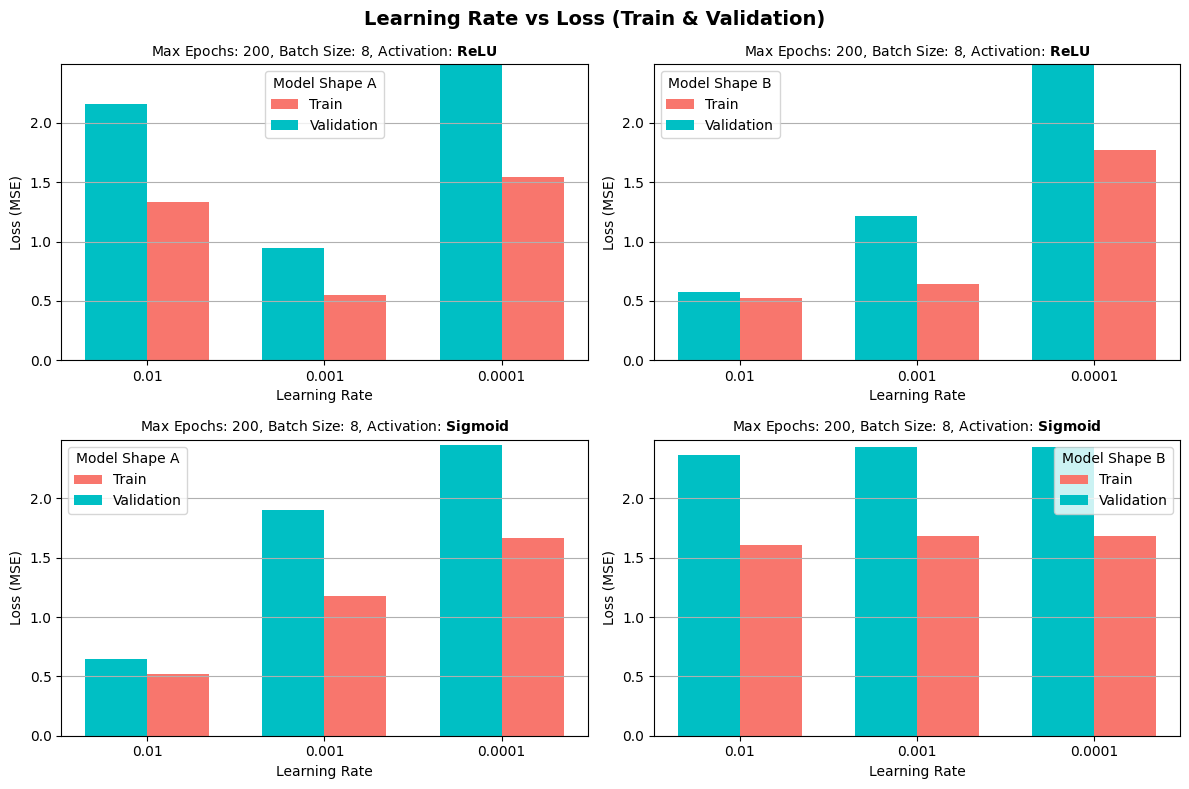

In [58]:
# Learning Rate vs Loss (Train and Validation)
plt.rcParams["text.usetex"] = False  # Must be False for \textbf{} with mathtext

E = 200

# top left
A_train_LR_relu = []
A_val_LR_relu = []

# top right
B_train_LR_relu = []
B_val_LR_relu = []

# bottom left
A_train_LR_sig = []
A_val_LR_sig = []

# bottom right
B_train_LR_sig = []
B_val_LR_sig = []

learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:

    # Model A - ReLU
    reset_seed()
    train_loss, val_loss, _, A_best_epoch_relu, _ = trainingLoop("A", E, 'ReLU', lr, 8, X_train, y_train, X_val, y_val, training=True)
    A_train_LR_relu.append(train_loss[A_best_epoch_relu])
    A_val_LR_relu.append(val_loss[A_best_epoch_relu])

    # Model B - ReLU
    reset_seed()
    train_loss, val_loss, _, B_best_epoch_relu, _ = trainingLoop("B", E, 'ReLU', lr, 8, X_train, y_train, X_val, y_val, training=True)
    B_train_LR_relu.append(train_loss[B_best_epoch_relu])
    B_val_LR_relu.append(val_loss[B_best_epoch_relu])

    # Model A - Sig
    reset_seed()
    train_loss, val_loss, _, A_best_epoch_sig, _ = trainingLoop("A", E, 'Sigmoid', lr, 8, X_train, y_train, X_val, y_val, training=True)
    A_train_LR_sig.append(train_loss[A_best_epoch_sig])
    A_val_LR_sig.append(val_loss[A_best_epoch_sig])

    # Model B - Sig
    reset_seed()
    train_loss, val_loss, _, B_best_epoch_sig, _ = trainingLoop("B", E, 'Sigmoid', lr, 8, X_train, y_train, X_val, y_val, training=True)
    B_train_LR_sig.append(train_loss[B_best_epoch_sig])
    B_val_LR_sig.append(val_loss[B_best_epoch_sig])

# Plot
x = np.arange(len(learning_rates))
bar_width = 0.35

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Model A - Relu
ax[0][0].bar(x + bar_width/2, A_train_LR_relu, width=bar_width, label='Train', color=train_col)
ax[0][0].bar(x - bar_width/2, A_val_LR_relu, width=bar_width, label='Validation', color=val_col)
ax[0][0].set_title(f"Max Epochs: {E}, Batch Size: 8, Activation: " + r"$\bf{ReLU}$", fontsize=10)
ax[0][0].set_xlabel("Learning Rate")
ax[0][0].set_ylabel("Loss (MSE)")
ax[0][0].set_xticks(x)
ax[0][0].set_xticklabels([str(lr) for lr in learning_rates])
ax[0][0].legend(title="Model Shape A")
ax[0][0].grid(True)

# Model B - Relu
ax[0][1].bar(x + bar_width/2, B_train_LR_relu, width=bar_width, label='Train', color=train_col)
ax[0][1].bar(x - bar_width/2, B_val_LR_relu, width=bar_width, label='Validation', color=val_col)
ax[0][1].set_title(f"Max Epochs: {E}, Batch Size: 8, Activation: " + r"$\bf{ReLU}$", fontsize=10)
ax[0][1].set_xlabel("Learning Rate")
ax[0][1].set_ylabel("Loss (MSE)")
ax[0][1].set_xticks(x)
ax[0][1].set_xticklabels([str(lr) for lr in learning_rates])
ax[0][1].legend(title="Model Shape B")
ax[0][1].grid(True)

# Model A - Sig
ax[1][0].bar(x + bar_width/2, A_train_LR_sig, width=bar_width, label='Train', color=train_col)
ax[1][0].bar(x - bar_width/2, A_val_LR_sig, width=bar_width, label='Validation', color=val_col)
ax[1][0].set_title(f"Max Epochs: {E}, Batch Size: 8, Activation: " + r"$\bf{Sigmoid}$", fontsize=10)
ax[1][0].set_xlabel("Learning Rate")
ax[1][0].set_ylabel("Loss (MSE)")
ax[1][0].set_xticks(x)
ax[1][0].set_xticklabels([str(lr) for lr in learning_rates])
ax[1][0].legend(title="Model Shape A")
ax[1][0].grid(True)

# Model B - sig
ax[1][1].bar(x + bar_width/2, B_train_LR_sig, width=bar_width, label='Train', color=train_col)
ax[1][1].bar(x - bar_width/2, B_val_LR_sig, width=bar_width, label='Validation', color=val_col)
ax[1][1].set_title(f"Max Epochs: {E}, Batch Size: 8, Activation: " + r"$\bf{Sigmoid}$", fontsize=10)
ax[1][1].set_xlabel("Learning Rate")
ax[1][1].set_ylabel("Loss (MSE)")
ax[1][1].set_xticks(x)
ax[1][1].set_xticklabels([str(lr) for lr in learning_rates])
ax[1][1].legend(title="Model Shape B")
ax[1][1].grid(True)


ymin = 0
ymax = max(max(A_train_LR_relu), max(A_val_LR_relu), max(B_train_LR_relu), max(A_val_LR_relu), max(A_train_LR_sig), max(A_val_LR_sig), max(B_train_LR_sig), max(A_val_LR_sig))
ax[0][0].set_ylim(ymin, ymax)
ax[0][1].set_ylim(ymin, ymax)
ax[1][0].set_ylim(ymin, ymax)
ax[1][1].set_ylim(ymin, ymax)

for row in ax:
    for col in row:
        col.grid(axis='x', visible=False)  # disables vertical gridlines
        # col.grid(axis='y', visible=False)  # disables horizontal gridlines

plt.suptitle("Learning Rate vs Loss (Train & Validation)", fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.90)  # leave space for suptitle
plt.show()

### Activation Function vs Loss

Sigmoid: Model A Val Loss = 0.6501
Sigmoid: Model B Val Loss = 2.3640
Early stopping at epoch 180 (patience=150)
ReLU: Model A Val Loss = 2.1573
ReLU: Model B Val Loss = 0.5736


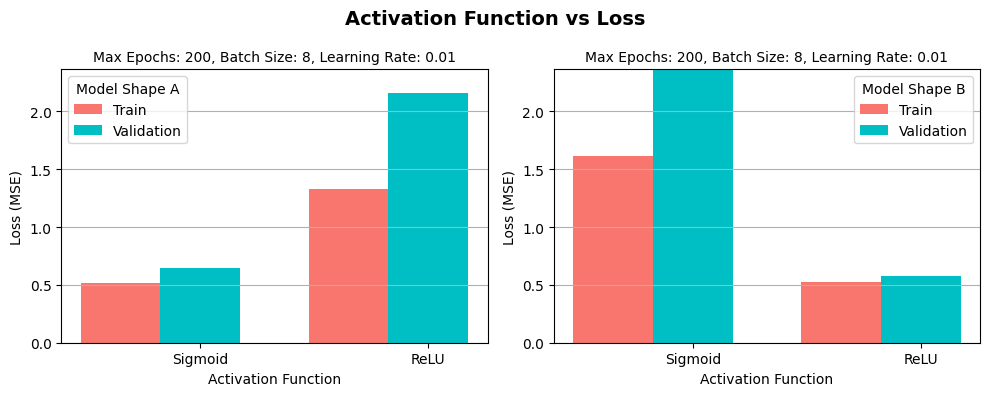

In [59]:
# Activation Function vs Loss (Train and Validation)
E = 200
activation_functions = ['Sigmoid', 'ReLU']

A_train_AF = []
A_val_AF = []

B_train_AF = []
B_val_AF = []


for af in activation_functions:
    # Model A
    reset_seed()
    train_loss, val_loss, _, A_best_epoch, _ = trainingLoop("A", E, af, 0.01, 8, X_train, y_train, X_val, y_val, training=True)
    A_train_AF.append(train_loss[A_best_epoch])
    A_val_AF.append(val_loss[A_best_epoch])

    print(f"{af}: Model A Val Loss = {val_loss[A_best_epoch]:.4f}")

    # Model B
    reset_seed()
    train_loss, val_loss, _, B_best_epoch, _ = trainingLoop("B", E, af, 0.01, 8, X_train, y_train, X_val, y_val, training=True)
    B_train_AF.append(train_loss[B_best_epoch])
    B_val_AF.append(val_loss[B_best_epoch])

    print(f"{af}: Model B Val Loss = {val_loss[B_best_epoch]:.4f}")


x = np.arange(len(activation_functions))
bar_width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Model A
ax[0].bar(x - bar_width, A_train_AF, width=bar_width, label='Train', color=train_col)
ax[0].bar(x, A_val_AF, width=bar_width, label='Validation', color=val_col)
ax[0].set_title(f"Max Epochs: {E}, Batch Size: 8, Learning Rate: 0.01", fontsize=10)
ax[0].set_xticks(x)
ax[0].set_xticklabels(activation_functions)
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_xlabel("Activation Function")
ax[0].legend(title='Model Shape A')
ax[0].grid(True)

# Model B
ax[1].bar(x - bar_width, B_train_AF, width=bar_width, label='Train', color=train_col)
ax[1].bar(x, B_val_AF, width=bar_width, label='Validation', color=val_col)
ax[1].set_title(f"Max Epochs: {E}, Batch Size: 8, Learning Rate: 0.01", fontsize=10)
ax[1].set_xticks(x)
ax[1].set_xticklabels(activation_functions)
ax[1].set_ylabel("Loss (MSE)")
ax[1].set_xlabel("Activation Function")
ax[1].legend(title='Model Shape B')
ax[1].grid(True)

ymin = 0
ymax = max(max(A_train_AF), max(B_train_AF), max(A_val_AF), max(B_val_AF))
ax[0].set_ylim(ymin, ymax)
ax[1].set_ylim(ymin, ymax)

for row in ax:
        row.grid(axis='x', visible=False)  # disables vertical gridlines
        # col.grid(axis='y', visible=False)  # disables horizontal gridlines

plt.suptitle("Activation Function vs Loss", fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.85)  # leave space for suptitle
plt.show()


### Batch Size vs Epoch Time

Early stopping at epoch 180 (patience=150)


<ipython-input-60-5d367caa8a0c>:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][0].legend(title="Model Shape A")
<ipython-input-60-5d367caa8a0c>:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][1].legend(title="Model Shape B")
<ipython-input-60-5d367caa8a0c>:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1][0].legend(title="Model Shape A")
<ipython-input-60-5d367caa8a0c>:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1][1].legend(title="Model Shape B")


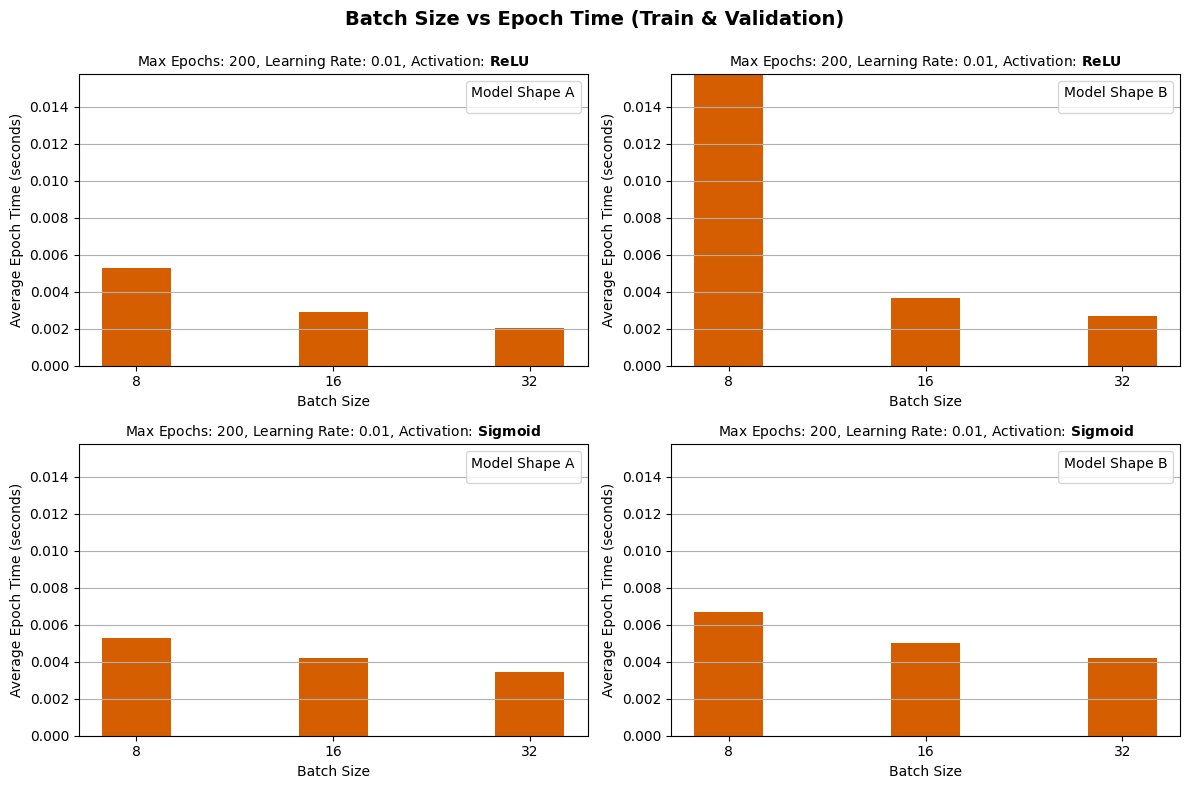

In [60]:
# Batch Size vs Epoch Time (Train and Validation)
plt.rcParams["text.usetex"] = False  # Must be False for \textbf{} with mathtext

E = 200

# top left
A_BS_epoch_times_relu = []

# top right
B_BS_epoch_times_relu = []

# bottom left
A_BS_epoch_times_sig = []

# bottom right
B_BS_epoch_times_sig = []


batch_sizes = [8, 16, 32]

for bs in batch_sizes:

    # Model A - ReLU
    reset_seed()
    _, _, epoch_times, _, _ = trainingLoop("A", E, 'ReLU', 0.01, bs, X_train, y_train, X_val, y_val, training=True)
    A_BS_epoch_times_relu.append(np.mean(epoch_times))


    # Model B - ReLU
    reset_seed()
    _, _, epoch_times, _, _ = trainingLoop("B", E, 'ReLU', 0.01, bs, X_train, y_train, X_val, y_val, training=True)
    B_BS_epoch_times_relu.append(np.mean(epoch_times))

    # Model A - Sig
    reset_seed()
    _, _, epoch_times, _, _ = trainingLoop("A", E, 'Sigmoid', 0.01, bs, X_train, y_train, X_val, y_val, training=True)
    A_BS_epoch_times_sig.append(np.mean(epoch_times))

    # Model B - Sig
    reset_seed()
    _, _, epoch_times, _, _ = trainingLoop("B", E, 'Sigmoid', 0.01, bs, X_train, y_train, X_val, y_val, training=True)
    B_BS_epoch_times_sig.append(np.mean(epoch_times))

# Plot
x = np.arange(len(batch_sizes))
bar_width = 0.35


fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Model A - Relu
ax[0][0].bar(x, A_BS_epoch_times_relu, width=bar_width, color='#D55E00')
ax[0][0].set_title(f"Max Epochs: {E}, Learning Rate: 0.01, Activation: " + r"$\bf{ReLU}$", fontsize=10)
ax[0][0].set_xlabel("Batch Size")
ax[0][0].set_ylabel("Average Epoch Time (seconds)")
ax[0][0].set_xticks(x)
ax[0][0].set_xticklabels([str(bs) for bs in batch_sizes])
ax[0][0].legend(title="Model Shape A")
ax[0][0].grid(True)

# Model B - Relu
ax[0][1].bar(x, B_BS_epoch_times_relu, width=bar_width, color='#D55E00')
ax[0][1].set_title(f"Max Epochs: {E}, Learning Rate: 0.01, Activation: " + r"$\bf{ReLU}$", fontsize=10)
ax[0][1].set_xlabel("Batch Size")
ax[0][1].set_ylabel("Average Epoch Time (seconds)")
ax[0][1].set_xticks(x)
ax[0][1].set_xticklabels([str(bs) for bs in batch_sizes])
ax[0][1].legend(title="Model Shape B")
ax[0][1].grid(True)

# Model A - Sig
ax[1][0].bar(x, A_BS_epoch_times_sig, width=bar_width, color='#D55E00')
ax[1][0].set_title(f"Max Epochs: {E}, Learning Rate: 0.01, Activation: " + r"$\bf{Sigmoid}$", fontsize=10)
ax[1][0].set_xlabel("Batch Size")
ax[1][0].set_ylabel("Average Epoch Time (seconds)")
ax[1][0].set_xticks(x)
ax[1][0].set_xticklabels([str(bs) for bs in batch_sizes])
ax[1][0].legend(title="Model Shape A")
ax[1][0].grid(True)

# Model B - sig
ax[1][1].bar(x, B_BS_epoch_times_sig, width=bar_width, color='#D55E00')
ax[1][1].set_title(f"Max Epochs: {E}, Learning Rate: 0.01, Activation: " + r"$\bf{Sigmoid}$", fontsize=10)
ax[1][1].set_xlabel("Batch Size")
ax[1][1].set_ylabel("Average Epoch Time (seconds)")
ax[1][1].set_xticks(x)
ax[1][1].set_xticklabels([str(bs) for bs in batch_sizes])
ax[1][1].legend(title="Model Shape B")
ax[1][1].grid(True)


ymax = max(max(A_BS_epoch_times_relu), max(B_BS_epoch_times_relu), max(A_BS_epoch_times_sig), max(B_BS_epoch_times_sig))
for row in ax:
    for col in row:
        col.set_ylim(0, ymax)

for row in ax:
    for col in row:
        col.grid(axis='x', visible=False)  # disables vertical gridlines
        # col.grid(axis='y', visible=False)  # disables horizontal gridlines

plt.suptitle("Batch Size vs Epoch Time (Train & Validation)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # leave space for suptitle
plt.show()

## Appendix
### 100 mappings

In [61]:
pd.set_option('display.max_rows', 100)
display(loadPopulationCSV(path='population.csv'))


,Penalty,Chromosome
0,6.4,"[5, 3, 2, 3, 5, 3, 1, 3, 3, 4]"
1,3.6,"[5, 5, 4, 5, 4, 1, 2, 2, 3, 5]"
2,4.2,"[1, 2, 3, 2, 4, 2, 2, 2, 1, 3]"
3,5.8,"[1, 5, 2, 3, 5, 1, 3, 3, 4, 3]"
4,3.6,"[4, 5, 3, 4, 5, 3, 4, 3, 1, 2]"
5,2.0,"[4, 1, 3, 4, 3, 4, 1, 2, 2, 3]"
6,2.4,"[2, 4, 3, 1, 3, 4, 1, 4, 5, 4]"
7,3.8,"[5, 2, 2, 5, 2, 3, 3, 4, 3, 3]"
8,3.6,"[4, 3, 1, 1, 1, 4, 1, 4, 3, 1]"
9,3.6,"[4, 3, 4, 4, 3, 3, 4, 2, 1, 1]"


### Alternative Hyperparamter Tuning - KFold Cross-Val

Replace Hyperparameter function in main code with below for Kfold Cross Val results.

In [62]:
# from sklearn.model_selection import KFold

# def tuneHyper_KFold(shape, k=5):
#     learning_rates = [0.01, 0.001, 0.0001]
#     batch_sizes = [8, 16, 32]
#     activation_types = ["ReLU", "Sigmoid"]
#     epochs = 200

#     results = []

#     # Load full dataset
#     X, y = createArrays(loadPopulationCSV())   # shape = (100, 110) and (100, 1)

#     kf = KFold(n_splits=k, shuffle=True, random_state=42)

#     for rate in learning_rates:
#         for batch_size in batch_sizes:
#             for activation in activation_types:
#                 val_losses = []

#                 for train_idx, val_idx in kf.split(X):
#                     # Get fold-specific train and validation sets
#                     X_train_fold, y_train_fold = X[train_idx], y[train_idx]
#                     X_val_fold, y_val_fold = X[val_idx], y[val_idx]

#                     # Reshape data splits into full tuple format expected by trainingLoop
#                     def splitOverride(X_all, y_all):
#                         return X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_val_fold, y_val_fold  # dummy test set

#                     # Monkey-patch the function (only works safely in a controlled script)
#                     global splitTrainValTestSets
#                     old_split = splitTrainValTestSets
#                     splitTrainValTestSets = splitOverride

#                     # Run training for this fold
#                     train_loss, val_loss, _, _, _ = trainingLoop(
#                         shape=shape,
#                         iterations=epochs,
#                         activation_type=activation,
#                         learning_rate=rate,
#                         batch_size=batch_size
#                     )

#                     val_losses.append(val_loss[-1])  # Final validation loss of this fold

#                     # Restore original split function
#                     splitTrainValTestSets = old_split

#                 avg_val_loss = sum(val_losses) / len(val_losses)

#                 results.append({
#                     "learning_rate": rate,
#                     "batch_size": batch_size,
#                     "activation": activation,
#                     "avg_val_loss": avg_val_loss,
#                 })

#     hyper_results = pd.DataFrame(results)
#     best_val = hyper_results.sort_values(by="avg_val_loss").iloc[0]

#     return best_val["activation"], best_val["learning_rate"], best_val["batch_size"]

# A_activation_type, A_learning_rate, A_batch_size = tuneHyper_KFold("A")
# B_activation_type, B_learning_rate, B_batch_size = tuneHyper_KFold("B")


### Predictions vs Actual

In [63]:
predA = A_test_pred_penalties.flatten()
predB = B_test_pred_penalties.flatten()
true = y_test.flatten()

# Create DataFrame
PvsA_models = pd.DataFrame({
    'Model A Predicted Penalty': predA,
    'Model B Predicted Penalty': predB,
    'Actual Penalty': true
})

print(PvsA_models)

# Summary table
summary = pd.DataFrame({
    'Model A':  [np.mean(predA), np.std(predA)],
    'Model B':  [np.mean(predB), np.std(predB)],
    'Actual': [np.mean(true), np.std(true)]
}, index=['Mean', 'Standard Deviation'])

print("\n")
print(summary)

    Model A Predicted Penalty  Model B Predicted Penalty  Actual Penalty
0                    1.851987                   2.017851             1.0
1                    2.480890                   2.422824             1.2
2                    2.373181                   2.321410             1.6
3                    2.513203                   2.596348             5.2
4                    3.588963                   3.169049             3.0
5                    3.930040                   3.771704             3.0
6                    2.011458                   2.135444             3.4
7                    2.284517                   2.217221             2.2
8                    3.657886                   3.264498             4.2
9                    4.119926                   3.971738             3.0
10                   2.478619                   2.482777             2.2
11                   3.242112                   3.059578             4.0
12                   3.041037                   2.9